In [1]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.color import rgb2hed
from matplotlib.colors import LinearSegmentedColormap

# Create an artificial color close to the original one
cmap_hema = LinearSegmentedColormap.from_list('mycmap', ['white', 'navy'])
cmap_dab = LinearSegmentedColormap.from_list('mycmap', ['white',
                                             'saddlebrown'])
cmap_eosin = LinearSegmentedColormap.from_list('mycmap', ['darkviolet',
                                               'white'])

ihc_rgb = data.immunohistochemistry()
ihc_hed = rgb2hed(ihc_rgb)

fig, axes = plt.subplots(2, 2, figsize=(7, 6), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(ihc_rgb)
ax[0].set_title("Original image")

ax[1].imshow(ihc_hed[:, :, 0], cmap=cmap_hema)
ax[1].set_title("Hematoxylin")

ax[2].imshow(ihc_hed[:, :, 1], cmap=cmap_eosin)
ax[2].set_title("Eosin")

ax[3].imshow(ihc_hed[:, :, 2], cmap=cmap_dab)
ax[3].set_title("DAB")

for a in ax.ravel():
    a.axis('off')

fig.tight_layout()

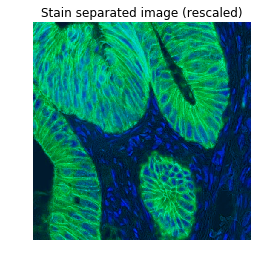

In [2]:
import numpy as np
from skimage.exposure import rescale_intensity

# Rescale hematoxylin and DAB signals and give them a fluorescence look
h = rescale_intensity(ihc_hed[:, :, 0], out_range=(0, 1))
d = rescale_intensity(ihc_hed[:, :, 2], out_range=(0, 1))
zdh = np.dstack((np.zeros_like(h), d, h))

fig = plt.figure()
axis = plt.subplot(1, 1, 1, sharex=ax[0], sharey=ax[0])
axis.imshow(zdh)
axis.set_title("Stain separated image (rescaled)")
axis.axis('off')
plt.show()

In [5]:
from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
from skimage import filters
from skimage import io

@adapt_rgb(each_channel)
def sobel_each(image):
    return filters.sobel(image)


@adapt_rgb(hsv_value)
def sobel_hsv(image):
    return filters.sobel(image)

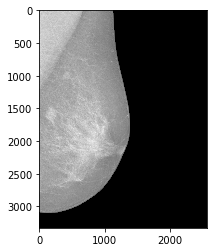

In [6]:
image = io.imread('test.png')
plt.imshow(image,cmap='gray')

Sobel

Text(0.5, 1.0, 'Sobel filter computed\n on (V)alue converted image (HSV)')

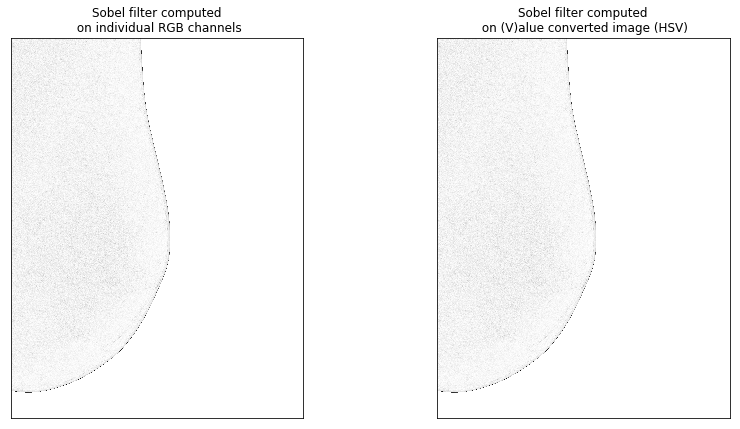

In [7]:
from skimage import data
from skimage import io
from skimage.exposure import rescale_intensity
import matplotlib.pyplot as plt

image = io.imread('test.png')

fig, (ax_each, ax_hsv) = plt.subplots(ncols=2, figsize=(14, 7))

# We use 1 - sobel_each(image) but this won't work if image is not normalized
ax_each.imshow(rescale_intensity(1 - sobel_each(image)),cmap='gray')
ax_each.set_xticks([]), ax_each.set_yticks([])
ax_each.set_title("Sobel filter computed\n on individual RGB channels")

# We use 1 - sobel_hsv(image) but this won't work if image is not normalized
ax_hsv.imshow(rescale_intensity(1 - sobel_hsv(image)),cmap='gray')
ax_hsv.set_xticks([]), ax_hsv.set_yticks([])
ax_hsv.set_title("Sobel filter computed\n on (V)alue converted image (HSV)")

Text(0.5, 1.0, 'Sobel filter computed\n on the converted grayscale image')

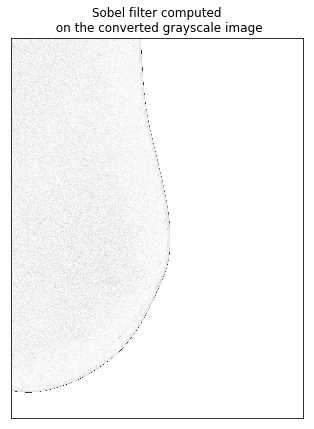

In [8]:
def sobel_gray(image):
    return filters.sobel(image)


fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7, 7))

# We use 1 - sobel_gray(image) but this won't work if image is not normalized
ax.imshow(rescale_intensity(1 - sobel_gray(image)), cmap=plt.cm.gray)
ax.set_xticks([]), ax.set_yticks([])
ax.set_title("Sobel filter computed\n on the converted grayscale image")


Filtering regional maxima

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction

# Convert to float: Important for subtraction later which won't work with uint8
#image = img_as_float(data.coins())
image = gaussian_filter(image, 1)

seed = np.copy(image)
seed[1:-1, 1:-1] = image.min()
mask = image

dilated = reconstruction(seed, mask, method='dilation')

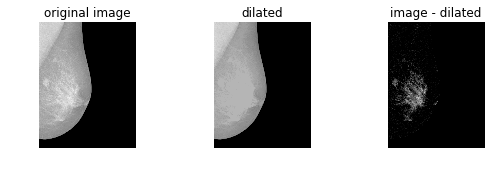

In [17]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(8, 2.5),
                                    sharex=True,
                                    sharey=True)

ax0.imshow(image, cmap='gray')
ax0.set_title('original image')
ax0.axis('off')

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(image - dilated, cmap='gray')
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()

In [18]:
h = 0.4
seed = image - h
dilated = reconstruction(seed, mask, method='dilation')
hdome = image - dilated

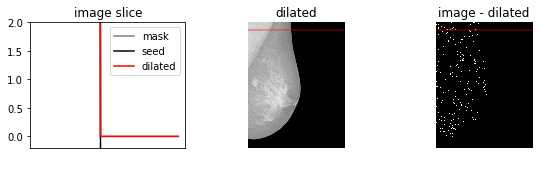

In [19]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8, 2.5))
yslice = 197

ax0.plot(mask[yslice], '0.5', label='mask')
ax0.plot(seed[yslice], 'k', label='seed')
ax0.plot(dilated[yslice], 'r', label='dilated')
ax0.set_ylim(-0.2, 2)
ax0.set_title('image slice')
ax0.set_xticks([])
ax0.legend()

ax1.imshow(dilated, vmin=image.min(), vmax=image.max(), cmap='gray')
ax1.axhline(yslice, color='r', alpha=0.4)
ax1.set_title('dilated')
ax1.axis('off')

ax2.imshow(hdome, cmap='gray')
ax2.axhline(yslice, color='r', alpha=0.4)
ax2.set_title('image - dilated')
ax2.axis('off')

fig.tight_layout()
plt.show()

Local Histogram Equalization

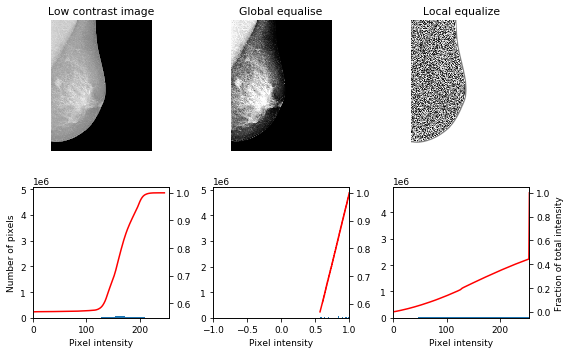

In [21]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from skimage import data
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte
from skimage import exposure
from skimage.morphology import disk
from skimage.filters import rank


matplotlib.rcParams['font.size'] = 9


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')

    xmin, xmax = dtype_range[image.dtype.type]
    ax_hist.set_xlim(xmin, xmax)

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')

    return ax_img, ax_hist, ax_cdf


# Load an example image
#img = img_as_ubyte(data.moon())

img = img_as_ubyte(image)
# Global equalize
img_rescale = exposure.equalize_hist(img)

# Equalization
selem = disk(30)
img_eq = rank.equalize(img, selem=selem)


# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')
ax_hist.set_ylabel('Number of pixels')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Global equalise')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Local equalize')
ax_cdf.set_ylabel('Fraction of total intensity')


# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [25]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,img_eq)
print(d)

7.331858860912288


Gamma and log contrast adjustment

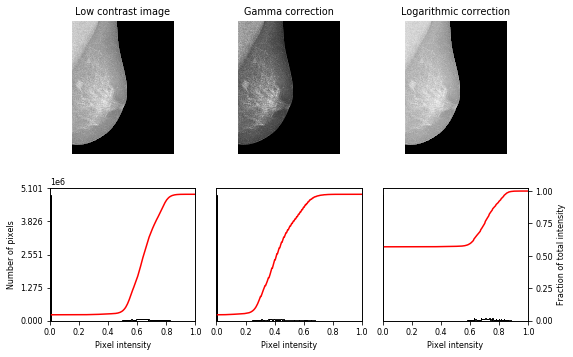

In [14]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure

matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image

#img = data.moon()
img = image
# Gamma
gamma_corrected = exposure.adjust_gamma(img, 2)

# Logarithmic
logarithmic_corrected = exposure.adjust_log(img, 1)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 3), dtype=np.object)
axes[0, 0] = plt.subplot(2, 3, 1)
axes[0, 1] = plt.subplot(2, 3, 2, sharex=axes[0, 0], sharey=axes[0, 0])
axes[0, 2] = plt.subplot(2, 3, 3, sharex=axes[0, 0], sharey=axes[0, 0])
axes[1, 0] = plt.subplot(2, 3, 4)
axes[1, 1] = plt.subplot(2, 3, 5)
axes[1, 2] = plt.subplot(2, 3, 6)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(gamma_corrected, axes[:, 1])
ax_img.set_title('Gamma correction')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(logarithmic_corrected, axes[:, 2])
ax_img.set_title('Logarithmic correction')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [28]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,logarithmic_corrected)
print(d)

31.08993224429178


In [26]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,gamma_corrected)
print(d)

31.91187931945491


Histogram Equalization

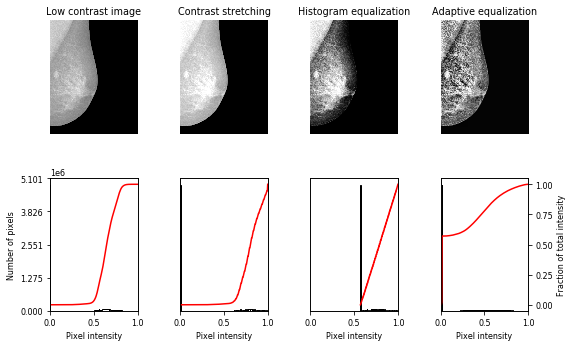

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
#img = data.moon()
img = image
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [29]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,img_rescale)
print(d)

30.86858410501922


In [30]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,img_eq)
print(d)

7.331858860912288


In [31]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,img_adapteq)
print(d)

7.318330636950744


Contour finding

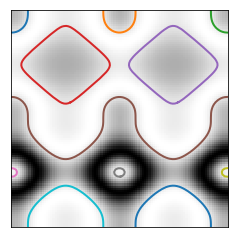

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure


# Construct some test data
x, y = np.ogrid[-np.pi:np.pi:100j, -np.pi:np.pi:100j]
r = np.sin(np.exp((np.sin(x)**3 + np.cos(y)**2)))

# Find contours at a constant value of 0.8
contours = measure.find_contours(r, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(r, interpolation='nearest', cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Convex Hull

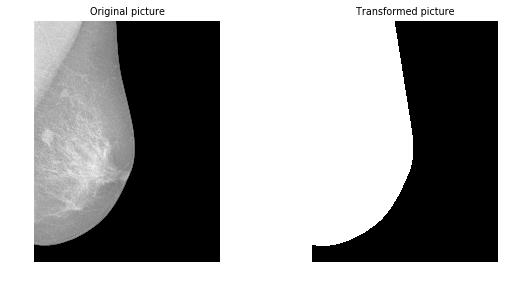

In [31]:
import matplotlib.pyplot as plt

from skimage.morphology import convex_hull_image
from skimage import data, img_as_float
from skimage.util import invert

# The original image is inverted as the object must be white.
#image = invert(data.horse())

chull = convex_hull_image(image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes.ravel()

ax[0].set_title('Original picture')
ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_axis_off()

ax[1].set_title('Transformed picture')
ax[1].imshow(chull, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_axis_off()

plt.tight_layout()
plt.show()


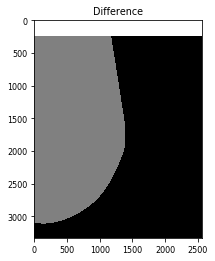

In [32]:
chull_diff = img_as_float(chull.copy())
chull_diff[image] = 2

fig, ax = plt.subplots()
ax.imshow(chull_diff, cmap=plt.cm.gray, interpolation='nearest')
ax.set_title('Difference')
plt.show()

Canny edge detector

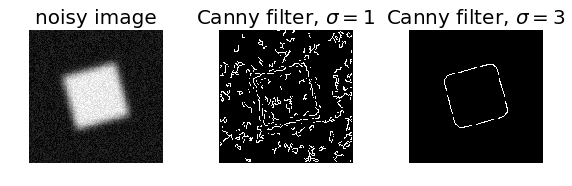

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndi.rotate(im, 15, mode='constant')
im = ndi.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

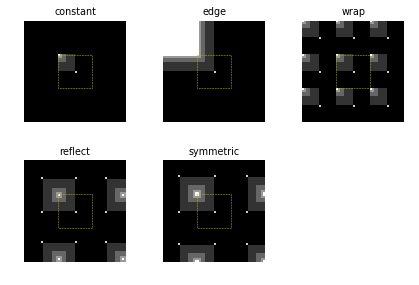

In [34]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.util import pad


img = np.zeros((16, 16))
img[:8, :8] += 1
img[:4, :4] += 1
img[:2, :2] += 1
img[:1, :1] += 2
img[8, 8] = 4

modes = ['constant', 'edge', 'wrap', 'reflect', 'symmetric']
fig, axes = plt.subplots(2, 3)
ax = axes.flatten()

for n, mode in enumerate(modes):
    img_padded = pad(img, pad_width=img.shape[0], mode=mode)
    ax[n].imshow(img_padded, cmap=plt.cm.gray, interpolation='nearest')
    ax[n].plot([15.5, 15.5, 31.5, 31.5, 15.5],
               [15.5, 31.5, 31.5, 15.5, 15.5], 'y--', linewidth=0.5)
    ax[n].set_title(mode)

for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

plt.tight_layout()
plt.show()

Histogram matching

In [37]:
import matplotlib.pyplot as plt
from skimage import data
from skimage import exposure
from skimage.transform import match_histograms

reference = data.coffee()
image = data.chelsea()

matched = match_histograms(image, reference, multichannel=True)

fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)
for aa in (ax1, ax2, ax3):
    aa.set_axis_off()

ax1.imshow(image)
ax1.set_title('Source')
ax2.imshow(reference)
ax2.set_title('Reference')
ax3.imshow(matched)
ax3.set_title('Matched')

plt.tight_layout()
plt.show()

ImportError: cannot import name 'match_histograms'

Structural similarity index

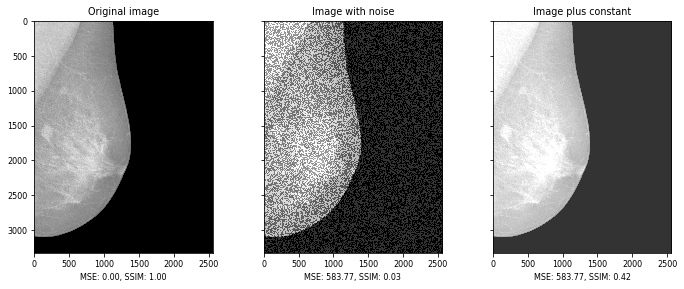

In [32]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim


#img = img_as_float(data.camera())
img = img_as_float(image)
rows, cols = img.shape

noise = np.ones_like(img) * 0.2 * (img.max() - img.min())
noise[np.random.random(size=noise.shape) > 0.5] *= -1

def mse(x, y):
    return np.linalg.norm(x - y)

img_noise = img + noise
img_const = img + abs(noise)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4),
                         sharex=True, sharey=True)
ax = axes.ravel()

mse_none = mse(img, img)
ssim_none = ssim(img, img, data_range=img.max() - img.min())

mse_noise = mse(img, img_noise)
ssim_noise = ssim(img, img_noise,
                  data_range=img_noise.max() - img_noise.min())

mse_const = mse(img, img_const)
ssim_const = ssim(img, img_const,
                  data_range=img_const.max() - img_const.min())

label = 'MSE: {:.2f}, SSIM: {:.2f}'

ax[0].imshow(img, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[0].set_xlabel(label.format(mse_none, ssim_none))
ax[0].set_title('Original image')

ax[1].imshow(img_noise, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[1].set_xlabel(label.format(mse_noise, ssim_noise))
ax[1].set_title('Image with noise')

ax[2].imshow(img_const, cmap=plt.cm.gray, vmin=0, vmax=1)
ax[2].set_xlabel(label.format(mse_const, ssim_const))
ax[2].set_title('Image plus constant')

plt.tight_layout()
plt.show()

In [35]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,mse_const)
print(d)

-7.189858700200741


Cross-Correlation (Phase Correlation)

Known offset (y, x): (-22.4, 13.32)


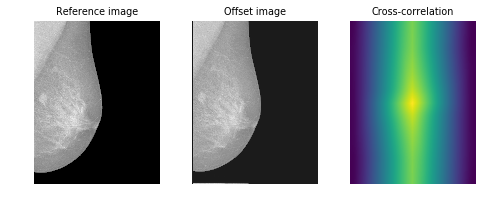

Detected pixel offset (y, x): [ 22. -13.]


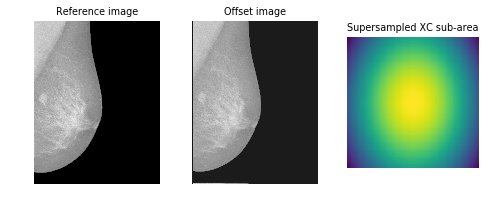

Detected subpixel offset (y, x): [ 22.4  -13.32]


In [36]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.feature import register_translation
from skimage.feature.register_translation import _upsampled_dft
from scipy.ndimage import fourier_shift

#image = data.camera()
shift = (-22.4, 13.32)
# The shift corresponds to the pixel offset relative to the reference image
offset_image = fourier_shift(np.fft.fftn(image), shift)
offset_image = np.fft.ifftn(offset_image)
print("Known offset (y, x): {}".format(shift))

# pixel precision first
shift, error, diffphase = register_translation(image, offset_image)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Show the output of a cross-correlation to show what the algorithm is
# doing behind the scenes
image_product = np.fft.fft2(image) * np.fft.fft2(offset_image).conj()
cc_image = np.fft.fftshift(np.fft.ifft2(image_product))
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Cross-correlation")

plt.show()

print("Detected pixel offset (y, x): {}".format(shift))

# subpixel precision
shift, error, diffphase = register_translation(image, offset_image, 100)

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Offset image')

# Calculate the upsampled DFT, again to show what the algorithm is doing
# behind the scenes.  Constants correspond to calculated values in routine.
# See source code for details.
cc_image = _upsampled_dft(image_product, 150, 100, (shift*100)+75).conj()
ax3.imshow(cc_image.real)
ax3.set_axis_off()
ax3.set_title("Supersampled XC sub-area")


plt.show()

print("Detected subpixel offset (y, x): {}".format(shift))

In [ ]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,mse_const)
print(d)

Masked Normalized Cross-Correlation

In [40]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import data, draw
from skimage.feature import masked_register_translation
from scipy import ndimage as ndi

mage = data.camera()
shift = (-22, 13)

corrupted_pixels = np.random.choice([False, True],
                                    size = image.shape,
                                    p = [0.25, 0.75])

# The shift corresponds to the pixel offset relative to the reference image
offset_image = ndi.shift(image, shift)
offset_image *= corrupted_pixels
print("Known offset (row, col): {}".format(shift))

# Determine what the mask is based on which pixels are invalid
# In this case, we know what the mask should be since we corrupted
# the pixels ourselves
mask = corrupted_pixels

detected_shift = masked_register_translation(image, offset_image, mask)

print("Detected pixel offset (row, col): {}".format(-detected_shift))

fig = plt.figure(figsize=(8, 3))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2, sharex=ax1, sharey=ax1)
ax3 = plt.subplot(1, 3, 3, sharex=ax1, sharey=ax1)

ax1.imshow(image, cmap='gray')
ax1.set_axis_off()
ax1.set_title('Reference image')

ax2.imshow(offset_image.real, cmap='gray')
ax2.set_axis_off()
ax2.set_title('Corrupted, offset image')

ax3.imshow(mask, cmap='gray')
ax3.set_axis_off()
ax3.set_title('Masked pixels')


plt.show()

ImportError: cannot import name 'masked_register_translation'

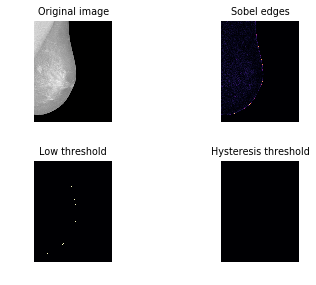

In [42]:
import matplotlib.pyplot as plt
from skimage import data, filters

fig, ax = plt.subplots(nrows=2, ncols=2)

#image = data.coins()
edges = filters.sobel(image)

low = 0.1
high = 0.35

lowt = (edges > low).astype(int)
hight = (edges > high).astype(int)
hyst = filters.apply_hysteresis_threshold(edges, low, high)

ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original image')

ax[0, 1].imshow(edges, cmap='magma')
ax[0, 1].set_title('Sobel edges')

ax[1, 0].imshow(lowt, cmap='magma')
ax[1, 0].set_title('Low threshold')

ax[1, 1].imshow(hight + hyst, cmap='magma')
ax[1, 1].set_title('Hysteresis threshold')

for a in ax.ravel():
    a.axis('off')

plt.tight_layout()

plt.show()

Image Deconvolution

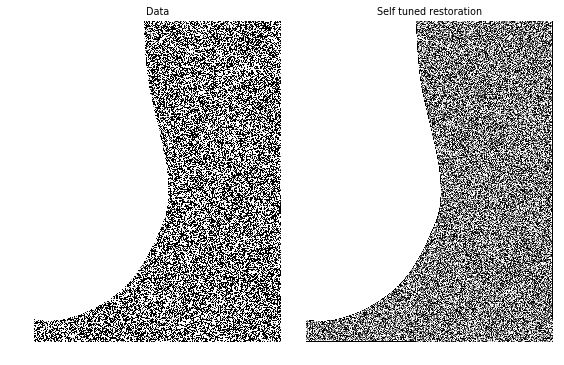

In [45]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

#astro = color.rgb2gray(data.astronaut())
astro = color.rgb2gray(image)
from scipy.signal import convolve2d as conv2
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
astro += 0.1 * astro.std() * np.random.standard_normal(astro.shape)

deconvolved, _ = restoration.unsupervised_wiener(astro, psf)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

ax[0].imshow(astro, vmin=deconvolved.min(), vmax=deconvolved.max())
ax[0].axis('off')
ax[0].set_title('Data')

ax[1].imshow(deconvolved)
ax[1].axis('off')
ax[1].set_title('Self tuned restoration')

fig.tight_layout()

plt.show()


Mean filters

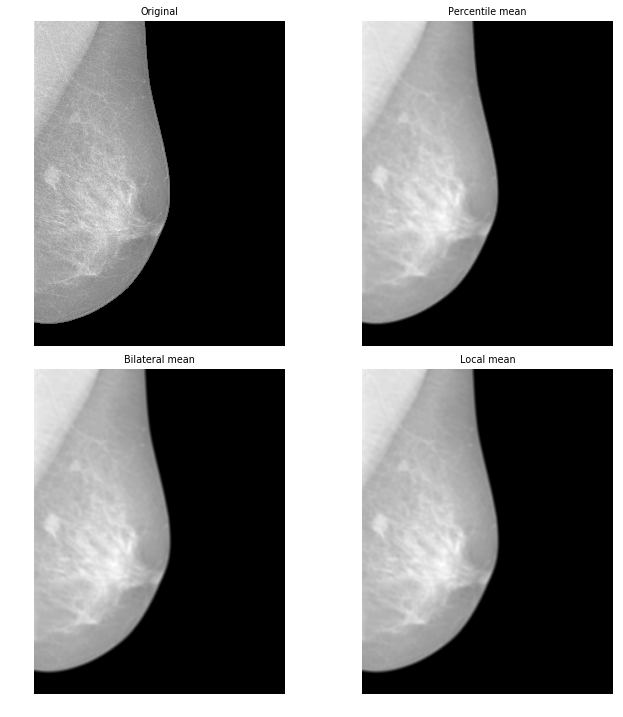

In [37]:
import matplotlib.pyplot as plt

from skimage import data
from skimage.morphology import disk
from skimage.filters import rank


#image = data.coins()
selem = disk(20)

percentile_result = rank.mean_percentile(image, selem=selem, p0=.1, p1=.9)
bilateral_result = rank.mean_bilateral(image, selem=selem, s0=500, s1=500)
normal_result = rank.mean(image, selem=selem)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10),
                         sharex=True, sharey=True)
ax = axes.ravel()

titles = ['Original', 'Percentile mean', 'Bilateral mean', 'Local mean']
imgs = [image, percentile_result, bilateral_result, normal_result]
for n in range(0, len(imgs)):
    ax[n].imshow(imgs[n], cmap=plt.cm.gray)
    ax[n].set_title(titles[n])
    ax[n].axis('off')

plt.tight_layout()
plt.show()


In [41]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img,normal_result)
print(d)

7.3687250607247226


Unsharp masking

In [49]:
from skimage import data
from skimage.filters import unsharp_mask
import matplotlib.pyplot as plt

#image = data.moon()
result_1 = unsharp_mask(image, radius=1, amount=1)
result_2 = unsharp_mask(image, radius=5, amount=2)
result_3 = unsharp_mask(image, radius=20, amount=1)

fig, axes = plt.subplots(nrows=2, ncols=2,
                         sharex=True, sharey=True, figsize=(10, 10))
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original image')
ax[1].imshow(result_1, cmap=plt.cm.gray)
ax[1].set_title('Enhanced image, radius=1, amount=1.0')
ax[2].imshow(result_2, cmap=plt.cm.gray)
ax[2].set_title('Enhanced image, radius=5, amount=2.0')
ax[3].imshow(result_3, cmap=plt.cm.gray)
ax[3].set_title('Enhanced image, radius=20, amount=1.0')

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

ImportError: cannot import name 'unsharp_mask'

Image Deconvolution

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/restoration/deconvolution.py:389: RuntimeWarning: divide by zero encountered in true_divide
  relative_blur = image / convolve_method(im_deconv, psf, 'same')
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/signal/signaltools.py:391: RuntimeWarning: invalid value encountered in multiply
  ret = (np.fft.irfftn(sp1 * sp2, fshape)[fslice].copy())
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/restoration/deconvolution.py:393: RuntimeWarning: invalid value encountered in greater
  im_deconv[im_deconv > 1] = 1
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/restoration/deconvolution.py:394: RuntimeWarning: invalid value encountered in less
  im_deconv[im_deconv < -1] = -1


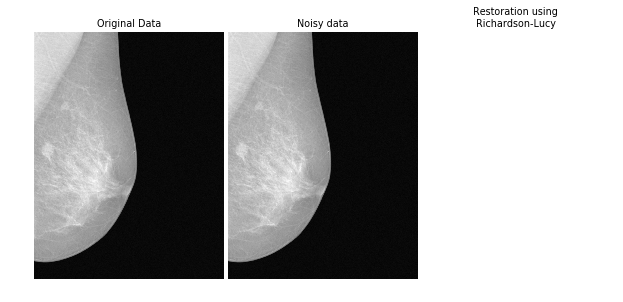

In [50]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve2d as conv2

from skimage import color, data, restoration

#astro = color.rgb2gray(data.astronaut())
#astro = color.rgb2gray(data.astronaut())
psf = np.ones((5, 5)) / 25
astro = conv2(astro, psf, 'same')
# Add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (np.random.poisson(lam=25, size=astro.shape) - 10) / 255.

# Restore Image using Richardson-Lucy algorithm
deconvolved_RL = restoration.richardson_lucy(astro_noisy, psf, iterations=30)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5))
plt.gray()

for a in (ax[0], ax[1], ax[2]):
       a.axis('off')

ax[0].imshow(astro)
ax[0].set_title('Original Data')

ax[1].imshow(astro_noisy)
ax[1].set_title('Noisy data')

ax[2].imshow(deconvolved_RL, vmin=astro_noisy.min(), vmax=astro_noisy.max())
ax[2].set_title('Restoration using\nRichardson-Lucy')


fig.subplots_adjust(wspace=0.02, hspace=0.2,
                    top=0.9, bottom=0.05, left=0, right=1)
plt.show()

Entropy

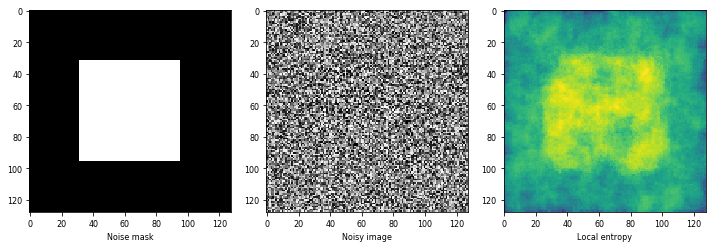

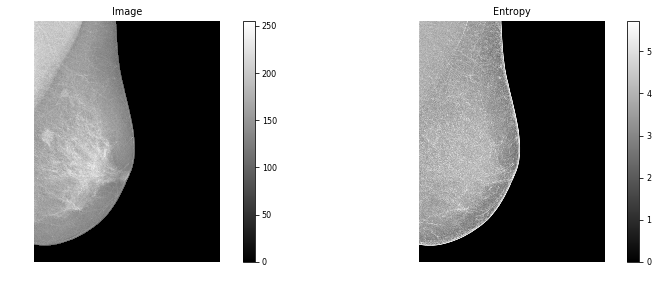

In [54]:
import matplotlib.pyplot as plt
import numpy as np

from skimage import data
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from skimage.morphology import disk

# First example: object detection.

noise_mask = np.full((128, 128), 28, dtype=np.uint8)
noise_mask[32:-32, 32:-32] = 30

noise = (noise_mask * np.random.random(noise_mask.shape) - 0.5 *
         noise_mask).astype(np.uint8)
img = noise + 128

entr_img = entropy(img, disk(10))

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

ax0.imshow(noise_mask, cmap='gray')
ax0.set_xlabel("Noise mask")
ax1.imshow(img, cmap='gray')
ax1.set_xlabel("Noisy image")
ax2.imshow(entr_img, cmap='viridis')
ax2.set_xlabel("Local entropy")

fig.tight_layout()

# Second example: texture detection.

#image = img_as_ubyte(data.camera())
image = img_as_ubyte(image)
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(12, 4),
                               sharex=True, sharey=True)

img0 = ax0.imshow(image, cmap=plt.cm.gray)
ax0.set_title("Image")
ax0.axis("off")
fig.colorbar(img0, ax=ax0)

img1 = ax1.imshow(entropy(image, disk(5)), cmap='gray')
ax1.set_title("Entropy")
ax1.axis("off")
fig.colorbar(img1, ax=ax1)

fig.tight_layout()

plt.show()

Denoising a picture

Estimated Gaussian noise standard deviation = 0.15088827394219778


ValueError: Use ``multichannel=False`` for 2D grayscale images. The last axis of the input image must be multiple color channels not another spatial dimension.

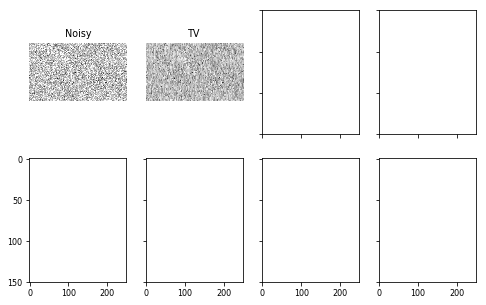

In [57]:
import matplotlib.pyplot as plt

from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage import data, img_as_float
from skimage.util import random_noise


#original = img_as_float(data.chelsea()[100:250, 50:300])
original = img_as_float(image[100:250, 50:300])
sigma = 0.155
noisy = random_noise(original, var=sigma**2)

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),
                       sharex=True, sharey=True)

plt.gray()

# Estimate the average noise standard deviation across color channels.
sigma_est = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
# Due to clipping in random_noise, the estimate will be a bit smaller than the
# specified sigma.
print("Estimated Gaussian noise standard deviation = {}".format(sigma_est))

ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')
ax[0, 1].imshow(denoise_tv_chambolle(noisy, weight=0.1, multichannel=True))
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')
ax[0, 2].imshow(denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,
                multichannel=True))
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')
ax[0, 3].imshow(denoise_wavelet(noisy, multichannel=True))
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

ax[1, 1].imshow(denoise_tv_chambolle(noisy, weight=0.2, multichannel=True))
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')
ax[1, 2].imshow(denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,
                multichannel=True))
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')
ax[1, 3].imshow(denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True))
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

Thresholding

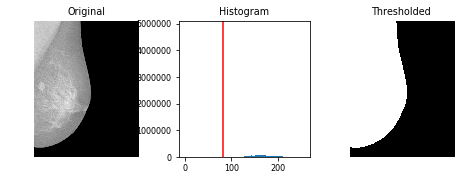

In [58]:
import matplotlib.pyplot as plt
from skimage import data
from skimage.filters import threshold_otsu
#image = data.camera()
image = io.imread('test.png')
thresh = threshold_otsu(image)
binary = image > thresh

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/skimage/filters/thresholding.py:601: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


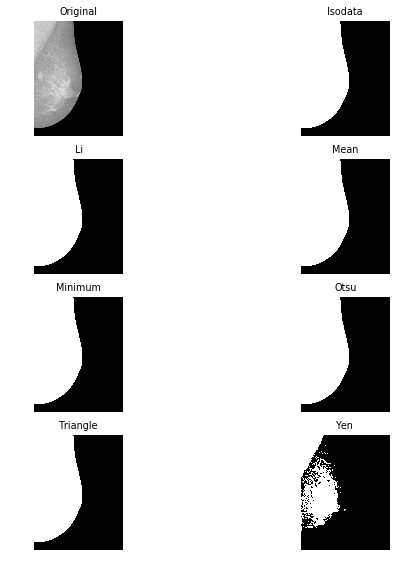

In [59]:
from skimage.filters import try_all_threshold

img = image

# Here, we specify a radius for local thresholding algorithms.
# If it is not specified, only global algorithms are called.
fig, ax = try_all_threshold(img, figsize=(10, 8), verbose=False)
plt.show()

In [10]:
from skimage import io
image = io.imread('test.png')

Chan-Vese Segmentation

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import chan_vese
from skimage import io
image = io.imread('test.png')

image = img_as_float(image)

# Feel free to play around with the parameters to see how they impact the result
cv = chan_vese(image, mu=0.25, lambda1=1, lambda2=1, tol=1e-3, max_iter=200,
               dt=0.5, init_level_set="checkerboard", extended_output=True)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ax = axes.flatten()

ax[0].imshow(image, cmap="gray")
ax[0].set_axis_off()
ax[0].set_title("Original Image", fontsize=12)

ax[1].imshow(cv[0], cmap="gray")
ax[1].set_axis_off()
title = "Chan-Vese segmentation - {} iterations".format(len(cv[2]))
ax[1].set_title(title, fontsize=12)

ax[2].imshow(cv[1], cmap="gray")
ax[2].set_axis_off()
ax[2].set_title("Final Level Set", fontsize=12)

ax[3].plot(cv[2])
ax[3].set_title("Evolution of energy over iterations", fontsize=12)

fig.tight_layout()
plt.show()

KeyboardInterrupt: 

Random walker segmentation

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.segmentation import random_walker
from skimage.data import binary_blobs
from skimage.exposure import rescale_intensity
import skimage

# Generate noisy synthetic data
#data = skimage.img_as_float(binary_blobs(length=128, seed=1))
data = skimage.img_as_float(image)
sigma = 0.35
data += np.random.normal(loc=0, scale=sigma, size=data.shape)
data = rescale_intensity(data, in_range=(-sigma, 1 + sigma),
                         out_range=(-1, 1))

# The range of the binary image spans over (-1, 1).
# We choose the hottest and the coldest pixels as markers.
markers = np.zeros(data.shape, dtype=np.uint)
markers[data < -0.95] = 1
markers[data > 0.95] = 2

# Run random walker algorithm
labels = random_walker(data, markers, beta=10, mode='bf')

# Plot results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3.2),
                                    sharex=True, sharey=True)
ax1.imshow(data, cmap='gray', interpolation='nearest')
ax1.axis('off')
ax1.set_title('Noisy data')
ax2.imshow(markers, cmap='magma', interpolation='nearest')
ax2.axis('off')
ax2.set_title('Markers')
ax3.imshow(labels, cmap='gray', interpolation='nearest')
ax3.axis('off')
ax3.set_title('Segmentation')

fig.tight_layout()
plt.show()

Watershed segmentation

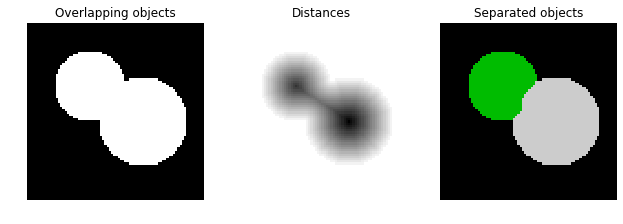

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max


# Generate an initial image with two overlapping circles
x, y = np.indices((80, 80))
x1, y1, x2, y2 = 28, 28, 44, 52
r1, r2 = 16, 20
mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
image = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

Extrema

In [11]:
import numpy as np

import matplotlib.pyplot as plt

from skimage.measure import label
from skimage import data
from skimage import color
from skimage.morphology import extrema
from skimage import exposure


#color_image = data.hubble_deep_field()

color_image = image
# for illustration purposes, we work on a crop of the image.
x_0 = 70
y_0 = 354
width = 100
height = 100

#img = color.rgb2gray(color_image)[y_0:(y_0 + height), x_0:(x_0 + width)]

# the rescaling is done only for visualization purpose.
# the algorithms would work identically in an unscaled version of the
# image. However, the parameter h needs to be adapted to the scale.
img = exposure.rescale_intensity(image)

MAXIMA DETECTION

In [12]:
# Maxima in the galaxy image are detected by mathematical morphology.
# There is no a priori constraint on the density.

# We find all local maxima
local_maxima = extrema.local_maxima(img)
label_maxima = label(local_maxima)
overlay = color.label2rgb(label_maxima, img, alpha=0.7, bg_label=0,
                          bg_color=None, colors=[(1, 0, 0)])

# We observed in the previous image, that there are many local maxima
# that are caused by the noise in the image.
# For this, we find all local maxima with a height of h.
# This height is the gray level value by which we need to descent
# in order to reach a higher maximum and it can be seen as a local
# contrast measurement.
# The value of h scales with the dynamic range of the image, i.e.
# if we multiply the image with a constant, we need to multiply
# the value of h with the same constant in order to achieve the same result.
h = 0.05
h_maxima = extrema.h_maxima(img, h)
label_h_maxima = label(h_maxima)
overlay_h = color.label2rgb(label_h_maxima, img, alpha=0.7, bg_label=0,
                            bg_color=None, colors=[(1, 0, 0)])

GRAPHICAL OUTPUT

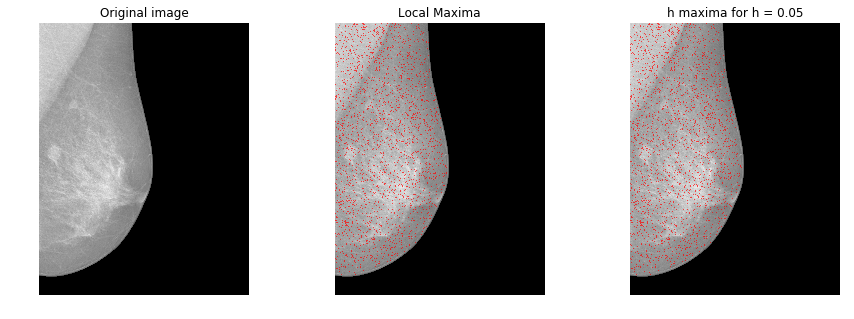

In [13]:
# a new figure with 3 subplots
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img, cmap='gray', interpolation='none')
ax[0].set_title('Original image')
ax[0].axis('off')

ax[1].imshow(overlay, interpolation='none')
ax[1].set_title('Local Maxima')
ax[1].axis('off')

ax[2].imshow(overlay_h, interpolation='none')
ax[2].set_title('h maxima for h = %.2f' % h)
ax[2].axis('off')
plt.show()

Morphological Filtering

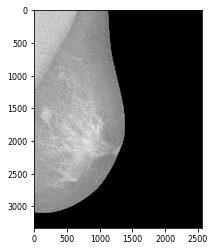

In [45]:
import os
import matplotlib.pyplot as plt
from skimage.data import data_dir
from skimage.util import img_as_ubyte
from skimage import io

#orig_phantom = img_as_ubyte(io.imread(os.path.join(data_dir, "phantom.png"),
#        as_gray=True))
orig_phantom= image
fig, ax = plt.subplots()
ax.imshow(orig_phantom, cmap=plt.cm.gray)

In [59]:
import numpy 
import math
import cv2
#original = cv2.imread("original.png")
#contrast = cv2.imread("photoshopped.png",1)
def psnr(img1, img2):
    mse = numpy.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

d=psnr(img, b_tophat)
print(d)

35.61229525459372


In [46]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

Erosion

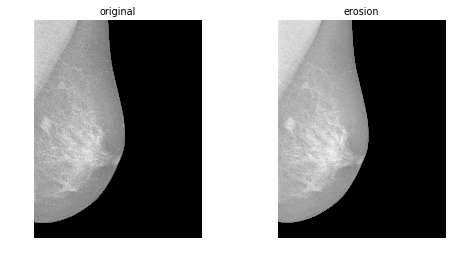

In [47]:
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
from skimage.morphology import black_tophat, skeletonize, convex_hull_image
from skimage.morphology import disk

selem = disk(6)
eroded = erosion(orig_phantom, selem)
plot_comparison(orig_phantom, eroded, 'erosion')

Dilation

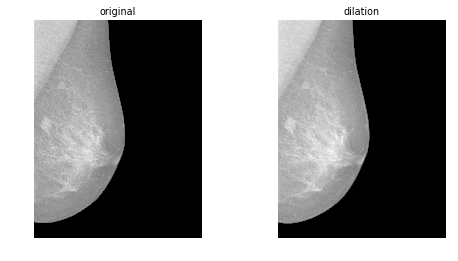

In [48]:
dilated = dilation(orig_phantom, selem)
plot_comparison(orig_phantom, dilated, 'dilation')

Opening

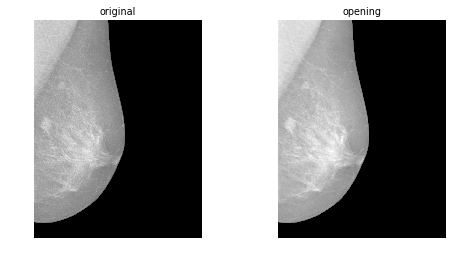

In [49]:
opened = opening(orig_phantom, selem)
plot_comparison(orig_phantom, opened, 'opening')

Closing

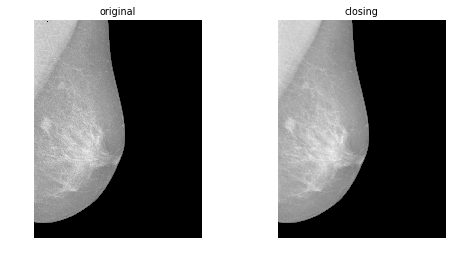

In [50]:
phantom = orig_phantom.copy()
phantom[10:30, 200:210] = 0

closed = closing(phantom, selem)
plot_comparison(phantom, closed, 'closing')


White tophat

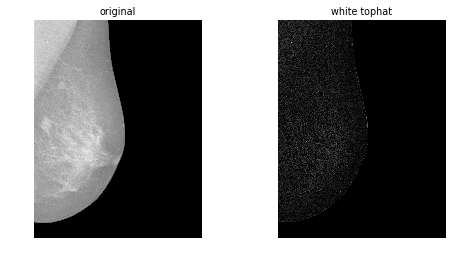

In [51]:
phantom = orig_phantom.copy()
phantom[340:350, 200:210] = 255
phantom[100:110, 200:210] = 0

w_tophat = white_tophat(phantom, selem)
plot_comparison(phantom, w_tophat, 'white tophat')

Black tophat

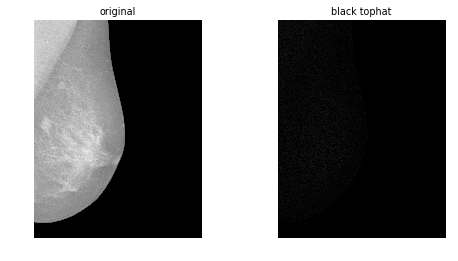

In [52]:
b_tophat = black_tophat(phantom, selem)
plot_comparison(phantom, b_tophat, 'black tophat')